<a href="https://colab.research.google.com/github/SambhavMishra/Mini-Project-VI-Semester/blob/Sambhav/resnet_facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"e61sambhavmishra","key":"328e47e778ca0311b59fed3e92e908b3"}'}

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 283M/285M [00:15<00:00, 25.6MB/s]
100% 285M/285M [00:15<00:00, 19.8MB/s]


In [ ]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!tar -zxvf /content/fer2013.tar.gz -C /content/


fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [ ]:
import torch 
import torch.nn as nn 
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import torch.optim as optim

In [ ]:
!mkdir datasets

In [ ]:
# Load the FER2013 dataset from the CSV file 
data = pd.read_csv("/content/fer2013/fer2013.csv") 

train_dataset = data[data["Usage"] == "Training"] 
test_dataset = data[data["Usage"] == "PublicTest"]

train_dataset.to_csv("datasets/train.csv", index=False) 
test_dataset.to_csv("datasets/test.csv", index=False)

In [ ]:
# Extract the pixel values and labels from the dataset
pixels = train_dataset['pixels'].tolist() 
labels = train_dataset['emotion'].tolist()

In [ ]:
# Convert the pixel values to grayscale images 
images = []
for pixel_sequence in pixels:
    pixel_array = np.array(pixel_sequence.split(), dtype=np.uint8) 
    image = pixel_array.reshape((48, 48)) 
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
    images.append(image) 

In [ ]:
# Print some statistics about the dataset 
print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")
print(f"Label distribution: {np.bincount(labels)}")

Number of images: 28709
Number of labels: 28709
Label distribution: [3995  436 4097 7215 4830 3171 4965]


## Labels:
*    Anger 
*    Disgust
*    Fear
*    Happy
*    Sadness 
*    Surprised 
*    Neutral

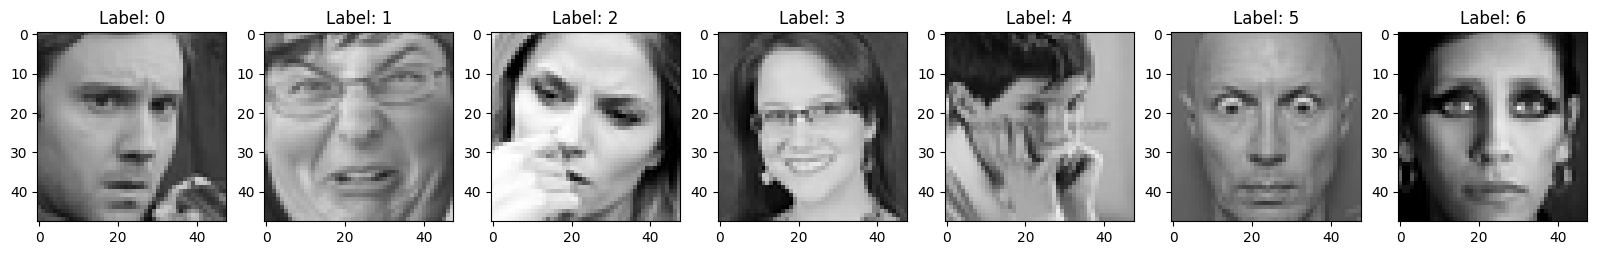

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(20, 10)) 
for label in range(7):
    image_index = labels.index(label) 
    pixel_sequence = pixels[image_index] 
    pixel_array = np.array(pixel_sequence.split(), dtype = np.uint8) 
    image = pixel_array.reshape((48, 48)) 
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
    axs[label].imshow(image) 
    axs[label].set_title(f"Label: {label}") 

plt.show()

In [ ]:
# Load the ResNet-50 model
resnet = models.resnet50(pretrained=True) 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


In [ ]:
num_classes = 7 # anger, disgust, fear, happiness, sadness, surprise, and neutral

# Set the number epochs and batch size
num_epochs = 50 
batch_size = 32

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file) 
        self.pixels = self.data['pixels'].tolist() 
        self.labels = self.data['emotion'].tolist()

    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        pixel_sequence = self.pixels[idx] 
        pixel_array = np.array(pixel_sequence.split(), dtype=np.uint8) 
        image = pixel_array.reshape((48, 48)) 
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()/255.0 
        label_tensor = torch.tensor(self.labels[idx], dtype = torch.long) 
        return image_tensor, label_tensor 
        

In [ ]:
# Load the FER2013 dataset 
train_dataset = FER2013Dataset('/content/datasets/train.csv') 
test_dataset = FER2013Dataset('/content/datasets/test.csv')

In [ ]:
# Create DataLoader objects for the training and testing sets

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True) 
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [ ]:
# Modify the last layer for emotion recognition
num_ftrs = resnet.fc.in_features 
resnet.fc = nn.Linear(num_ftrs, num_classes) # num_classes is the number of emotions to predict

In [ ]:
# Define the loss function and optimizer 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = resnet(inputs) 
        loss = criterion(outputs, labels) 

        # Backward pass and optimization 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

        # Compute statistics 
        running_loss += loss.item() 
        if i % 200 == 199: # Print statistics every 200 mini-batches 
            print('[Epoch %d, Mini-batch %d] Average Loss: %.3f' %(epoch + 1, i + 1, running_loss / 200)) 
            running_loss = 0.0 # Reset the running loss


[Epoch 1, Mini-batch 200] Average Loss: 0.827
[Epoch 1, Mini-batch 400] Average Loss: 0.900
[Epoch 1, Mini-batch 600] Average Loss: 0.911
[Epoch 1, Mini-batch 800] Average Loss: 0.909
[Epoch 2, Mini-batch 200] Average Loss: 0.644
[Epoch 2, Mini-batch 400] Average Loss: 0.707
[Epoch 2, Mini-batch 600] Average Loss: 0.727
[Epoch 2, Mini-batch 800] Average Loss: 0.761
[Epoch 3, Mini-batch 200] Average Loss: 0.485
[Epoch 3, Mini-batch 400] Average Loss: 0.527
[Epoch 3, Mini-batch 600] Average Loss: 0.605
[Epoch 3, Mini-batch 800] Average Loss: 0.629
[Epoch 4, Mini-batch 200] Average Loss: 0.377
[Epoch 4, Mini-batch 400] Average Loss: 0.433
[Epoch 4, Mini-batch 600] Average Loss: 0.482
[Epoch 4, Mini-batch 800] Average Loss: 0.513
[Epoch 5, Mini-batch 200] Average Loss: 0.316
[Epoch 5, Mini-batch 400] Average Loss: 0.384
[Epoch 5, Mini-batch 600] Average Loss: 0.388
[Epoch 5, Mini-batch 800] Average Loss: 0.421
[Epoch 6, Mini-batch 200] Average Loss: 0.278
[Epoch 6, Mini-batch 400] Average 

In [ ]:
# Evaluate the model on the testing set on GPU
correct = 0 
total = 0 
test_loss = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass on GPU
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute predictions on GPU
        _, predicted = torch.max(outputs.data, 1) 

        # Compute statistics on GPU
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 

        if i % 10 == 9:
            test_accuracy = 100 * correct / total 
            test_loss = test_loss / 10 
            print('[Mini-batch %d] Test Loss: %.3f, Test Accuracy: %.3f' %(i + 1, test_loss, test_accuracy))
            test_loss = 0.0 
            correct = 0
            total  = 0 

test_accuracy = 100 * correct / total 
print(f"Accuracy on the testing set: {test_accuracy}%")


[Mini-batch 10] Test Loss: 2.720, Test Accuracy: 65.312
[Mini-batch 20] Test Loss: 2.538, Test Accuracy: 66.875
[Mini-batch 30] Test Loss: 2.829, Test Accuracy: 65.312
[Mini-batch 40] Test Loss: 3.140, Test Accuracy: 64.688
[Mini-batch 50] Test Loss: 2.638, Test Accuracy: 65.938
[Mini-batch 60] Test Loss: 2.951, Test Accuracy: 64.062
[Mini-batch 70] Test Loss: 2.512, Test Accuracy: 63.438
[Mini-batch 80] Test Loss: 2.683, Test Accuracy: 65.938
[Mini-batch 90] Test Loss: 3.071, Test Accuracy: 61.250
[Mini-batch 100] Test Loss: 3.284, Test Accuracy: 61.875
[Mini-batch 110] Test Loss: 3.174, Test Accuracy: 60.000
Accuracy on the testing set: 62.31884057971015%


In [ ]:
# Save the model:
# Save the model to a file
torch.save(resnet.state_dict(), "resnet_model2.pt")
